In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
from dotenv import load_dotenv

from pathlib import Path

# Scikit-Learn models:

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse


import pickle
import warnings

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)
load_dotenv()
csv_path = os.getenv("PATHD")

dataset = pd.read_csv(csv_path)

df = dataset.copy()

In [4]:
df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,...,Quantity,Discount,Profit,Order Year,Order Month,Order Day,Order Month(N),CLV,Delivery Time (days),Ship Day
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,...,2,0.00,41.9136,2016,11,Tue,November,3146.243079,3,Fri
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,...,3,0.00,219.5820,2016,11,Tue,November,3146.243079,3,Fri
2,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,...,2,0.00,6.8714,2016,6,Sun,June,3066.005363,4,Thu
3,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,...,5,0.45,-383.0310,2015,10,Sun,October,7127.853161,7,Sun
4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,...,2,0.20,2.5164,2015,10,Sun,October,7127.853161,7,Sun


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9993 entries, 0 to 9992
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Order ID              9993 non-null   object 
 1   Order Date            9993 non-null   object 
 2   Ship Date             9993 non-null   object 
 3   Ship Mode             9993 non-null   object 
 4   Customer ID           9993 non-null   object 
 5   Customer Name         9993 non-null   object 
 6   Segment               9993 non-null   object 
 7   Country               9993 non-null   object 
 8   City                  9993 non-null   object 
 9   State                 9993 non-null   object 
 10  Postal Code           9993 non-null   int64  
 11  Region                9993 non-null   object 
 12  Product ID            9993 non-null   object 
 13  Category              9993 non-null   object 
 14  Sub-Category          9993 non-null   object 
 15  Product Name         

In [6]:
df.columns

Index(['Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID',
       'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code',
       'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name',
       'Sales', 'Quantity', 'Discount', 'Profit', 'Order Year', 'Order Month',
       'Order Day', 'Order Month(N)', 'CLV', 'Delivery Time (days)',
       'Ship Day'],
      dtype='object')

<Axes: >

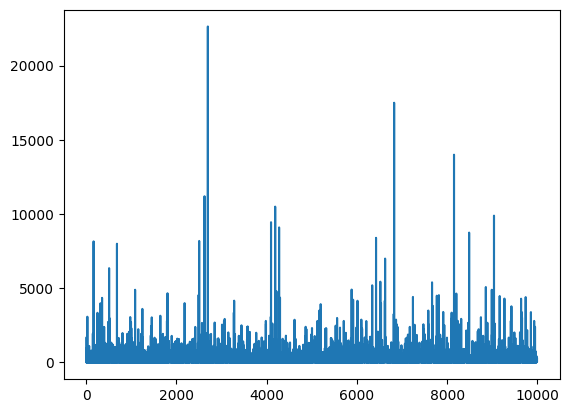

In [7]:
df['Sales'].plot()

In [8]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [9]:
df['Order Date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 9993 entries, 0 to 9992
Series name: Order Date
Non-Null Count  Dtype         
--------------  -----         
9993 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 78.2 KB


In [10]:
def get_sales_by_timeframe(data):
	"""
	Aggregates sales data by months and years. 

	Parameters:
	data (pd.Dataframe): A Dataset contains 'Order Date' and 'Sales' columns. 

	Returns: 
	Tuple: Two dataframes - one aggregated by months and another aggregated by years. 

	"""
	if not pd.api.types.is_datetime64_any_dtype(data['Order Date']):
		data['Order Date'] = pd.to_datetime(data['Order Date'])

	monthly_data = data.copy()
	monthly_data['Order Date'] = monthly_data['Order Date'].dt.to_period('M').dt.to_timestamp() # start of Month
	monthly_agg = monthly_data.groupby('Order Date', observed = True)['Sales'].sum().reset_index()

	yearly_data = data.copy()
	yearly_data['Order Date'] = yearly_data['Order Date'].dt.to_period('Y').dt.to_timestamp() # Start of the year
	yearly_agg = yearly_data.groupby('Order Date',observed=True)['Sales'].sum().reset_index()

	return monthly_agg, yearly_agg

In [11]:
monthly_sales , yearly_sales = get_sales_by_timeframe(df)


In [12]:
monthly_sales.head()

,Order Date,Sales
0,2014-01-01,14236.895
1,2014-02-01,4519.892
2,2014-03-01,55691.009
3,2014-04-01,28013.973
4,2014-05-01,23648.287


In [13]:
yearly_sales

,Order Date,Sales
0,2014-01-01,483966.1261
1,2015-01-01,470532.5090
2,2016-01-01,609205.5980
3,2017-01-01,733215.2552


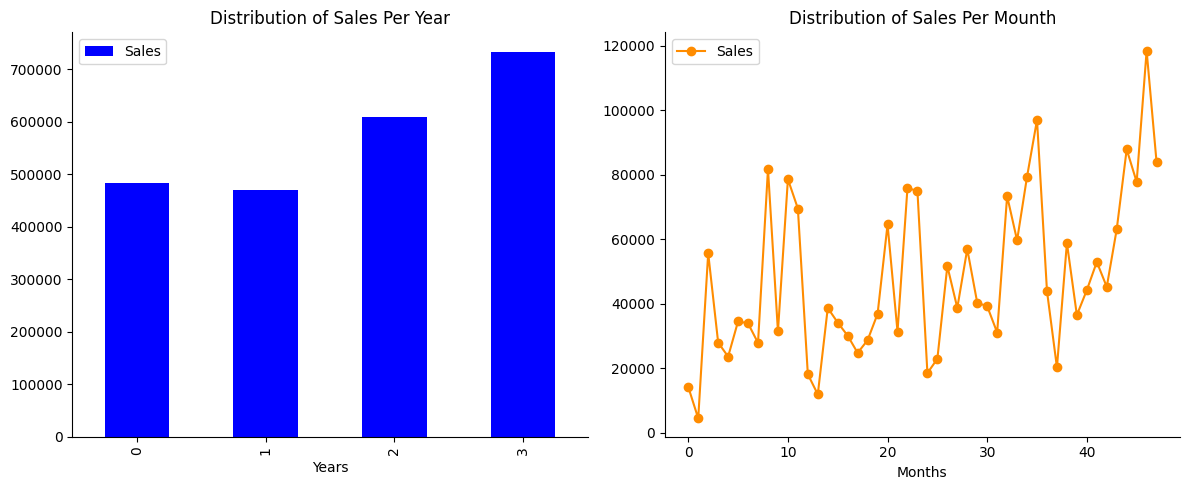

In [14]:
layout = (1,2)

raw = plt.subplot2grid(layout, (0,0))
law = plt.subplot2grid(layout, 
					   (0,1))

years = yearly_sales['Sales'].plot(kind='bar', color='Blue', label='Sales', ax=raw, figsize=(12,5))
months = monthly_sales["Sales"].plot(marker="o", color="darkorange", label="Sales", ax=law)

years.set(xlabel="Years", title="Distribution of Sales Per Year")
months.set(xlabel="Months", title="Distribution of Sales Per Mounth")

sns.despine()
plt.tight_layout()

years.legend()
months.legend()

In [17]:
def sales_time(data):
	"""
	Time interval of datset

	"""

	n_of_days = data['Order Date'].max() - data['Order Date'].min()
	n_of_years = data['Order Date'].dt.year.nunique()

	print(f"Days: {n_of_days.days}\nYears:{n_of_years}\nMonth: {12 * n_of_years}")

sales_time(df)

Days: 1457
Years:4
Month: 48


In [19]:
def sales_per_region(data):
	sales_by_region = data.groupby('Region',observed=True)['Sales'].sum().reset_index()
	sales_by_region = sales_by_region.sort_values(by="Sales", ascending=False)

	fig,ax = plt.subplots(figsize=(8,6))

	sns.barplot(
		x="Region", 
		y="Sales", 
		data=sales_by_region, 
		hue="Region",  # Assign the x variable to hue
		dodge=False,   # Ensure bars are not split
		palette="viridis" 
	)
	
	ax.set(xlabel = "Region", ylabel = "Sum of Sales", title = "Total Sales Per Region")  

	return sales_by_region

,Region,Sales
3,West,725457.8245
1,East,678499.8680
0,Central,501239.8908
2,South,391721.9050


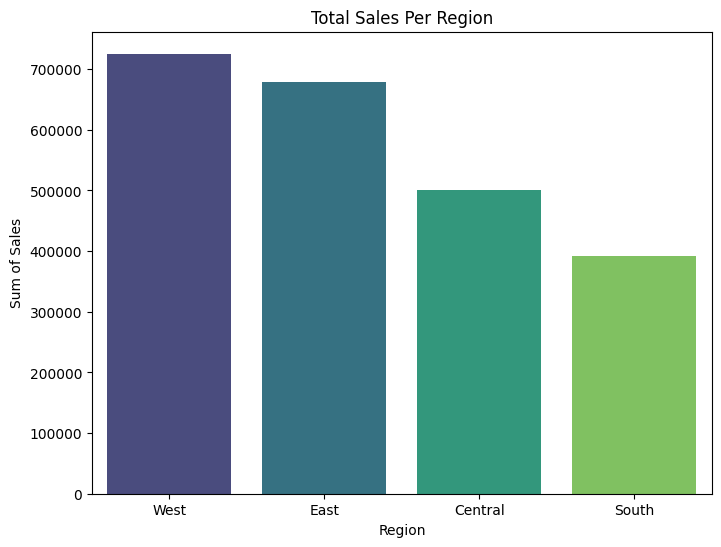

In [20]:
sales_per_region(df)

In [21]:
# Overall for four years: 

avg_m_sales = monthly_sales.Sales.mean()
print(f"Overall Average Monthly Sales: ${avg_m_sales}")

def avg_12months():
	# Last one year (This will be forecasted Sales)
	avg_m_sales_1y = monthly_sales.Sales[-12:].mean()
	print(f"Last 12 months average monthly sales: ${avg_m_sales_1y}")

avg_12months()	

Overall Average Monthly Sales: $47852.48933958334
Last 12 months average monthly sales: $61101.271266666656


# Determining Time Series Stationary

The idea is to analyze the trend and seasonality patterns in the time series, then remove these components to create a stationary series. A stationary series, which has constant mean and variance, is more suitable for applying statistical forecasting methods. Once predictions are made on the stationary series, the trend and seasonality components are reintroduced to transform the forecasted values back to their original scale.This approach ensures the final predictions reflect both the underlying patterns and the random fluctuations in the data. 

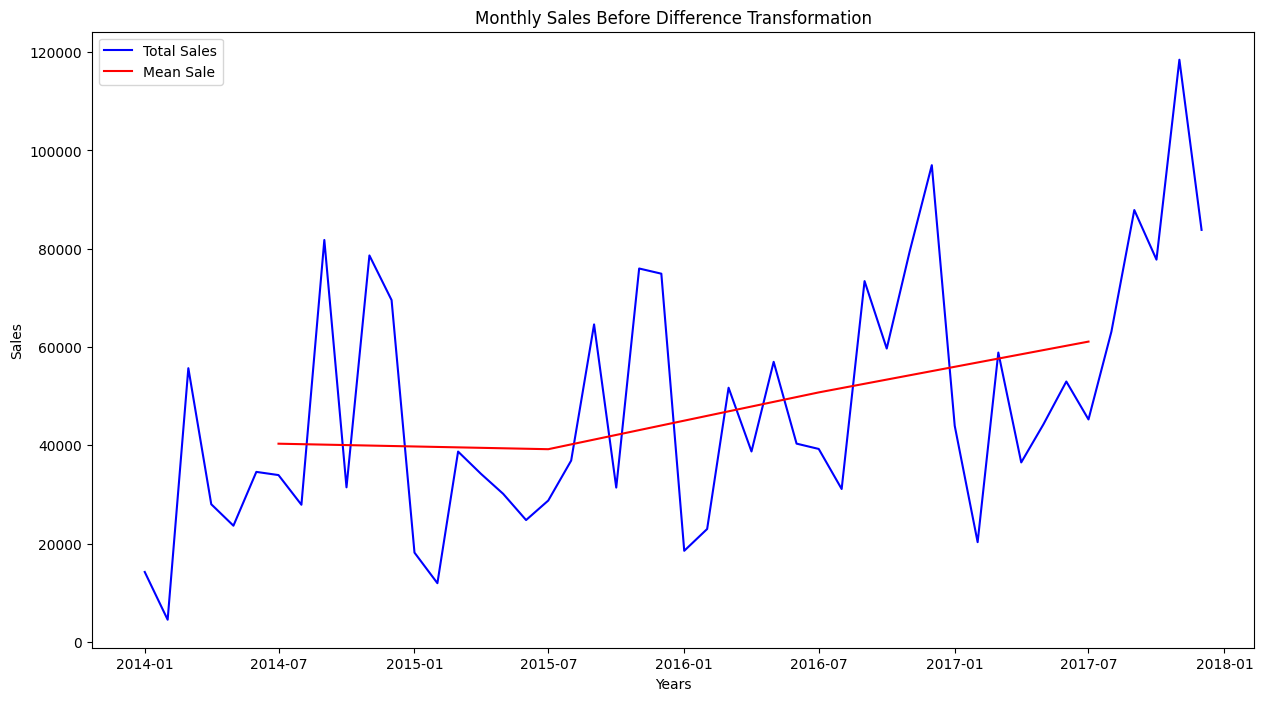

In [22]:
def time_plot(data, x_col, y_col, title):
	fig, ax = plt.subplots(figsize = (15,8))

	sns.lineplot(x=x_col, y=y_col, data=data, ax=ax, color='blue', label='Total Sales')
	s_mean = data.groupby(data[x_col].dt.year, observed=True)[y_col].mean().reset_index()
	s_mean[x_col] = pd.to_datetime(s_mean[x_col], format='%Y')

	sns.lineplot(
		x=(s_mean[x_col] + pd.DateOffset(months=6)),
		y=s_mean[y_col],
		ax=ax,
		color='red',
		label='Mean Sale'
	)

	ax.set(
		xlabel="Years",
		ylabel="Sales",
		title=title
	)

	plt.legend()
	plt.show()

time_plot(monthly_sales, 'Order Date', 'Sales', 'Monthly Sales Before Difference Transformation')	

The original series shows a clear upward trend

# Differencing 
We will compute the difference between consecutive values in the series. This process, called differencing, is commonly used to remove a changing mean from the data.
* Differencing is a technique used in time series analysis to make a non-stationary series(line with trends or changing averages) more stationary (constant mean and variance over time). 


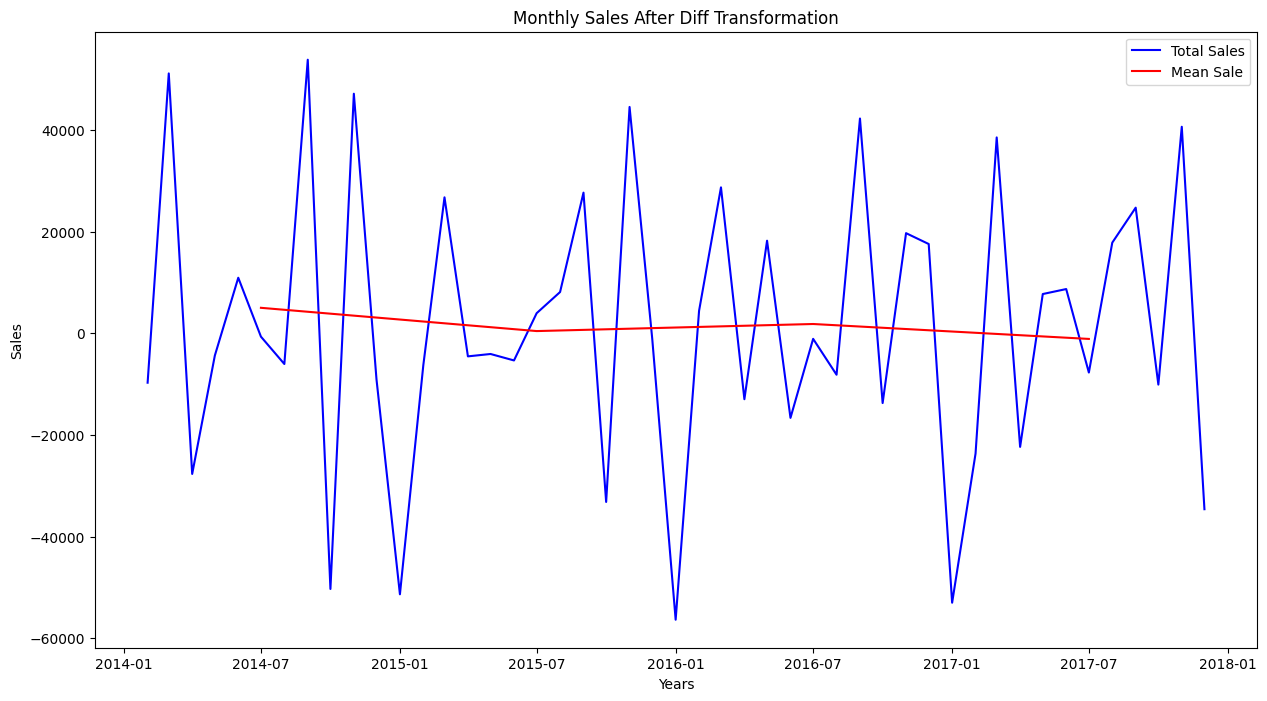

In [23]:
def calculate_monthly_difference(
    data, column="Sales", output_file="./stationary_df.csv"
):
    """Calculate month-over-month difference for a specified column in the dataset.
	   Parameters:
	   		data (pd.DataFrame): The input dataset
			column (str): The column for which to calculate the difference (default is 'sales')
			output_file (str): The file path to save the transformed dataset as a CSV file.

		Returns:
			pd.DataFrames: The dataset with the calculated difference column and NaN values dropped.	
	"""

    data[f'{column}_diff'] = data[column].diff()

    transformed_data = data.dropna()
    transformed_data.to_csv(output_file, index=False)

    return transformed_data


stationary_df = calculate_monthly_difference(monthly_sales, column='Sales')

time_plot(stationary_df, 'Order Date', 'Sales_diff', 'Monthly Sales After Diff Transformation')

Total Sale shows considerable spiked and dips, highlighting months with significant changes in sales. This suggests even after removing the trend, the series contains irregular patterns that could be due to seasionality or random fluctuations. 

Now we will prepare the data for different types of models, ensuring it represents monthly sales and has been transformed into a stationary format.  

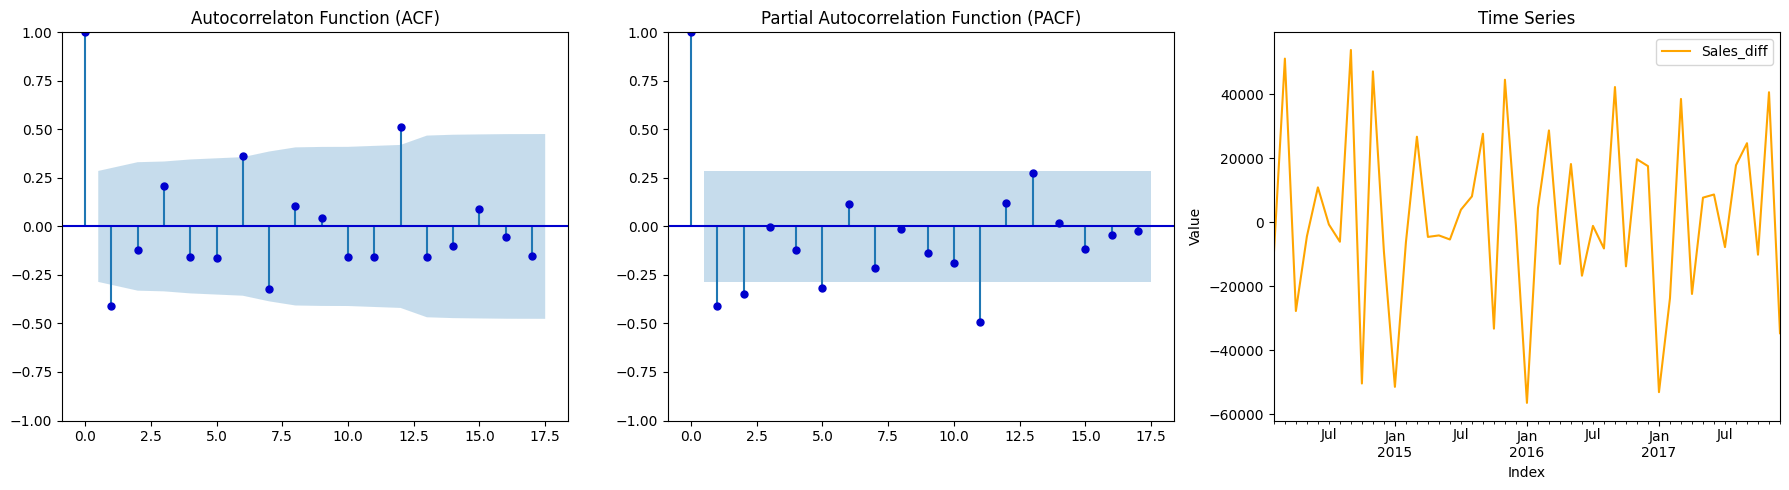

In [34]:
import statsmodels.graphics.tsaplots as smt

def plot_lags_alternative(data, lags=None):
	"""Plot time series, ACF, and PCAF with specified lags. 
	Parameters:
	-----------
	data : pandas.DataFrame
		Input DataFrame with time series data
	lags : int, optional
		Number of lags to plpt. If None, defaults to min(10, len(data)//2)
    """

	dt_data = data.set_index('Order Date').drop('Sales', axis=1).dropna()
	
	fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

	smt.plot_acf(dt_data, lags=lags, ax=ax1, color='mediumblue')
	ax1.set_title('Autocorrelaton Function (ACF)')

	smt.plot_pacf(dt_data, lags=lags, ax=ax2, color='mediumblue')
	ax2.set_title('Partial Autocorrelation Function (PACF)')

	dt_data.plot(ax=ax3, color='orange', title="Time Series")
	ax3.set_xlabel('Index')
	ax3.set_ylabel('Value')
	
	plt.tight_layout()
	plt.show()

plot_lags_alternative(stationary_df)	

# Regressive Modeling

In [35]:
def prepare_supervised_data(data, n_lags=12):
	"""
	Transforms time series data into a supervised learning format by adding lagged features 

	Args: 
	- data: pd.DataFrame
	- n_lags: Number of lag features to create.

	Returns: 
	- A DataFrame with the lagged features and no missing values.
	"""
	lagged_data = []

	for i in range(1, n_lags+1):
		lagged_data.append(data['Sales_diff'].shift(i))

	lagged_df = pd.concat(lagged_data, axis=1)

	lagged_df.columns = [f'lag_{i}' for i in range(1, n_lags + 1)]

	supervised_df = pd.concat([data, lagged_df], axis=1)

	supervised_df.dropna(inplace=True)

	supervised_df.to_csv('./supervised_model_data.csv', index=False)

	return supervised_df

supervised_data = prepare_supervised_data(stationary_df, n_lags=12)
supervised_data.head()

,Order Date,Sales,Sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
13,2015-02-01,11951.4110,-6222.6646,-51371.5449,-9083.0962,47175.3237,-50323.9578,53867.8823,-6036.9245,-648.7346,10946.8406,-4365.6860,-27677.0360,51171.1170,-9717.0030
14,2015-03-01,38726.2520,26774.8410,-6222.6646,-51371.5449,-9083.0962,47175.3237,-50323.9578,53867.8823,-6036.9245,-648.7346,10946.8406,-4365.6860,-27677.0360,51171.1170
15,2015-04-01,34195.2085,-4531.0435,26774.8410,-6222.6646,-51371.5449,-9083.0962,47175.3237,-50323.9578,53867.8823,-6036.9245,-648.7346,10946.8406,-4365.6860,-27677.0360
16,2015-05-01,30131.6865,-4063.5220,-4531.0435,26774.8410,-6222.6646,-51371.5449,-9083.0962,47175.3237,-50323.9578,53867.8823,-6036.9245,-648.7346,10946.8406,-4365.6860
17,2015-06-01,24797.2920,-5334.3945,-4063.5220,-4531.0435,26774.8410,-6222.6646,-51371.5449,-9083.0962,47175.3237,-50323.9578,53867.8823,-6036.9245,-648.7346,10946.8406


We seperate our dataset, allocating the last 12 months to the test set while using the remaining data to train the model

# Train and Test Data

In [36]:
def train_test_split(data):
	data = data.drop(['Sales', 'Order Date'], axis=1)
	train, test = data[:-12].values, data[-12:].values

	return train, test

train, test = train_test_split(supervised_data)
print(f'Shape of Train : {train.shape}\nShape of Test:{test.shape}')

Shape of Train : (23, 13)
Shape of Test:(12, 13)


# Scaling Data

In [37]:
def scale_data(train_set, test_set):
	"""Scales data using MinMaxScaker and seperates data in to X_train, y_train, X_test, and y_test.
	"""

	# Applying Min Max Scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train_set)

	# Reshapping training set
	train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
	train_set_scaled = scaler.transform(train_set)

	# Reshape test set
	test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
	test_set_scaled = scaler.transform(test_set)

	X_train, y_train = train_set_scaled[:, 1:],train_set_scaled[:,0:1].ravel() # Returns the array, flattened
	X_test, y_test = test_set_scaled[:,1:],test_set_scaled[:, 0:1].ravel()

	return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)
print(f'Shape of X train: {X_train.shape}\nShape of y Train: {y_train.shape}\nShape of X test: {X_test.shape}\nShape of y test: {y_test.shape}')

Shape of X train: (23, 12)
Shape of y Train: (23,)
Shape of X test: (12, 12)
Shape of y test: (12,)


# Reverse Scaling

Model outputs (predictions) are in scaled range. For comparison with the original data or visualization, we need the predictions back in the original scale.

In [38]:
def re_scaling(y_pred, x_test, scaler_object, lstm=False):
	"""For visualizing and comparing results, undoes the scaling effect on predictins."""

	y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)

	if not lstm:
		x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

	pred_test_set = []
	for index in range(0, len(y_pred)):
		pred_test_set.append(np.concatenate([y_pred[index], x_test[index]], axis=1))

	pred_test_set = np.array(pred_test_set)
	pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

	pred_test_set_inverted = scaler_object.inverse_transform(pred_test_set)

	return pred_test_set_inverted

# Predictions DataFrame

In [39]:
def prediction_df(unscale_predictions, origin_df):
    """Generates a dataframe that shows the predicted sales for each month for ploting results.
    Parameters:
    -----------
    unscale_predictions: the model predictions that do not have min-max or other scaling applied

    origin_df: the original monthly sales applied.
    """
    result_list = []
    sales_dates = list(origin_df[-12:]["Order Date"])
    act_sales = list(origin_df[-12:]["Sales"])

    for index in range(len(unscale_predictions)):
        result_dict = {}
        result_dict["pred_value"] = int(
            unscale_predictions[index][0] + act_sales[index]
        )
        result_dict["Order Date"] = sales_dates[index]
        result_list.append(result_dict)
    df_result = pd.DataFrame(result_list)
    return df_result

# Model Score

In [40]:
model_scores = {}

def get_scores(unscale_df, origin_df, model_name):
    """Prints the root mean squared error, mean absolute error, and r2 scores for each model. Saves all results in a model_scores dictionary for comparison """

    rmse = np.sqrt(mean_squared_error(origin_df['Sales'][-12:], unscale_df.pred_value[-12:]))

    mae = mean_absolute_error(origin_df['Sales'][-12:],unscale_df.pred_value[-12:])

    r2 = r2_score(origin_df['Sales'][-12:], unscale_df.pred_value[-12:])

    model_scores[model_name] = [rmse,mae, r2]	

    print(f"RMSE: {rmse}\nMAE: {mae}\nR2 Score: {r2}")

# Graph
plot_result function for ploting a line graph of the model.

In [41]:
def plot_results(results, origin_df, model_name):
	fig, ax = plt.subplots(figsize=(15,5))
	sns.lineplot(x='Order Date',y='Sales', data=origin_df, ax=ax,
			  label='Original', color='blue')
	sns.lineplot(x='Order Date', y='pred_value', data=results, ax=ax, label='Predicted', color='red')
	
	ax.set(xlabel="Date",
		ylabel='Sales',
		title=f'{model_name} Sales Forecasting Prediction')
	
	ax.legend(loc='best')

	filepath = Path(f'./model_output/{model_name}_forecasting.svg')
	filepath.parent.mkdir(parents=True,exist_ok=True)
	plt.savefig(f'./model_output/{model_name}_forecasting.svg')

In [42]:
def regressive_model(train_data, test_data, model, model_name):
	"""Runs regressive models in Sklearn framework. First, calls scale_dar to split into X and y and scate the data. Then fits and predicts. Finally, predictions are unscaled, scores are printed, and results are plotted and saved. """

	X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)

	mod = model
	mod.fit(X_train, y_train)
	predictions = mod.predict(X_test)
	
	origin_df = monthly_sales
	unscaled = re_scaling(predictions, X_test, scaler_object)
	unscaled_df = prediction_df(unscaled, origin_df)
	#print(unscaled_df)

	get_scores(unscaled_df, origin_df, model_name)
	plot_results(unscaled_df, origin_df, model_name)


# Modeling 

* Linear Rgression
* Random Forest Regressor
* XGBoost


# Linear Regression

RMSE: 23893.07692319679
MAE: 18004.410316666665
R2 Score: 0.14059533161147408


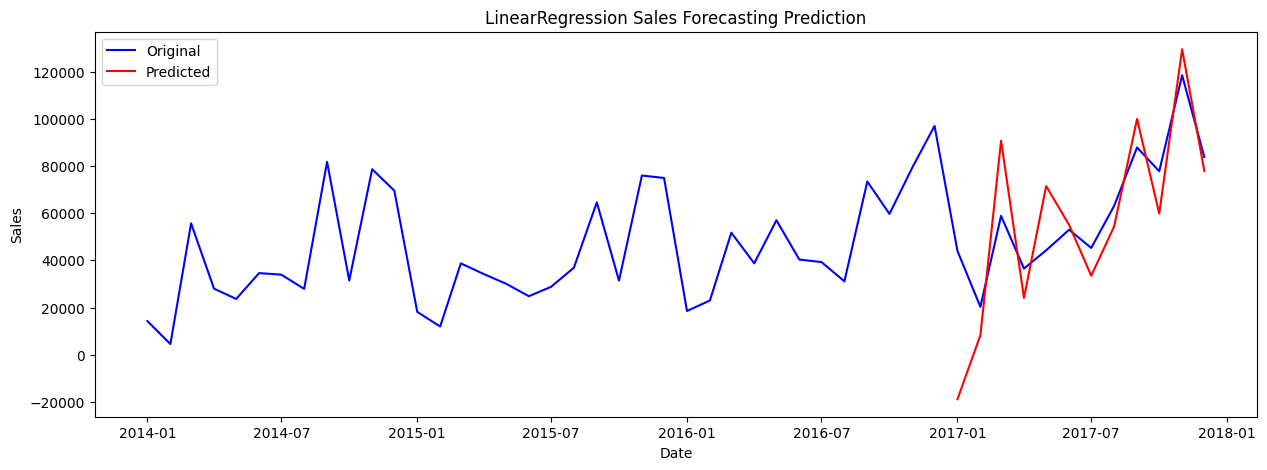

In [43]:
regressive_model(train, test, LinearRegression(), 'LinearRegression')

# Random Forest Regressor

RMSE: 18374.05243303898
MAE: 14165.1448
R2 Score: 0.49176631202968457


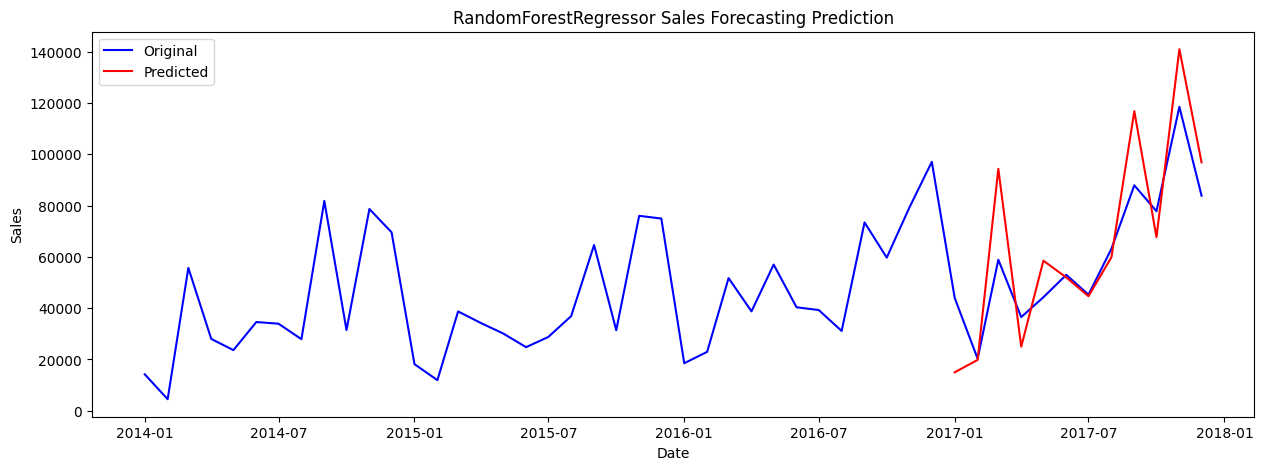

In [44]:
regressive_model(train, test, RandomForestRegressor(n_estimators=100,max_depth=20), 'RandomForestRegressor')

# XGBOOST

RMSE: 18886.193886990102
MAE: 14481.575466666667
R2 Score: 0.46303938325631144


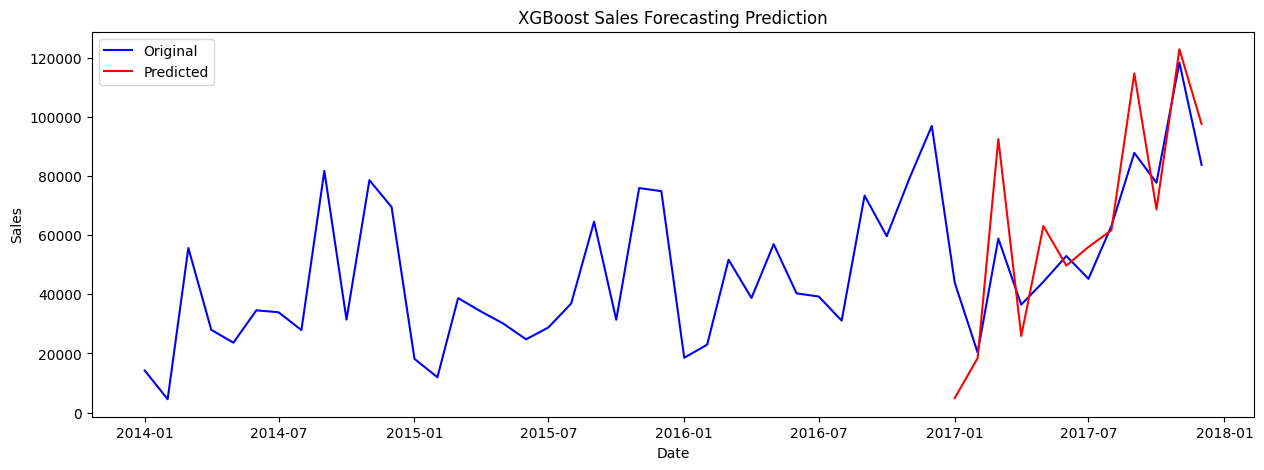

In [45]:
regressive_model(train, test, XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.2, objective='reg:squarederror'), 'XGBoost')

# Compare Model

,Model,RMSE,MAE,R2
0,LinearRegression,23893.076923,18004.410317,0.140595
1,XGBoost,18886.193887,14481.575467,0.463039
2,RandomForestRegressor,18374.052433,14165.144800,0.491766


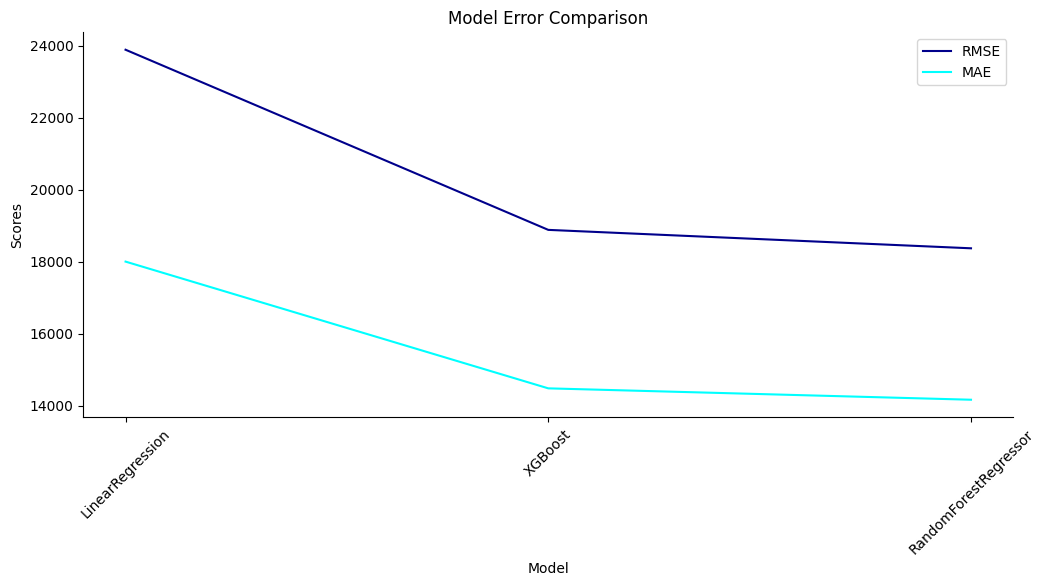

In [46]:
def create_results_df():
	if not model_scores:
		print("No model score found")
		return None
	
	results_df = pd.DataFrame.from_dict(model_scores, orient='index',
									 columns=['RMSE', 'MAE', 'R2'])
	
	results_df = results_df.sort_values(by='RMSE', ascending=False).reset_index()
	results_df.rename(columns={"index": "Model"}, inplace=True)

	results_df.to_csv(f'./results.csv', index=False)

	fig, ax = plt.subplots(figsize=(12, 5))
	sns.lineplot(x='Model', y='RMSE', data=results_df, ax=ax, label='RMSE', color='darkblue')

	sns.lineplot(x='Model', y='MAE', data=results_df, ax=ax, label='MAE', color='cyan')

	plt.xticks(rotation=45)
	ax.set(xlabel="Model",
		   ylabel="Scores",
		   title='Model Error Comparison')
	sns.despine()

	plt.savefig(f'./model_output/compare_models.png')

	return results_df

results = create_results_df()
results

In [47]:
avg_12months()

Last 12 months average monthly sales: $61101.271266666656


In [48]:
average = 61101.271266666656
RandomForest = results.MAE.values[2]
percentage_off = round(RandomForest / average * 100, 2)
print(f"With Random Forest, prediction is within {percentage_off}% of the actual.")

With Random Forest, prediction is within 23.18% of the actual.
